In [1]:
## Importing standards libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
#import torch

## Importing libraries for the Gaussian Mixture Model

from scipy.stats import multivariate_normal
from scipy.stats import norm
import seaborn as sns

## Convergence metrics

from scipy.stats import wasserstein_distance
from scipy.stats import entropy # KL-divergence


## Import functions for the experiment : 

from experiment_functions import *
from IPLA_Exp_Functions import *
from IPLA_functions_MMLE_V2 import *

### MMLE Experiment with Banana Distribution

In this example, we will work on $ \mathbb{R}^{dx} $ Let us assume the following “banana” prior:

$ p(x) \propto \exp\left(-\frac{x_1^2}{10} - \frac{x_2^2}{10} - 2(x_2 - x_1^2)^2\right), $

where $ x \in \mathbb{R}^{dx} $ We would like to then use the following likelihood:

$ p(y|x) = \mathcal{N}(y; Hx, \sigma^2 I), $

where $ H \in \mathbb{R}^{dx} $ and $ y \in \mathbb{R} $ 

Our first goal is to sample from $ p(x|y) $ efficiently given the parameter $H$. Then, we will proceed to estimate the Maximum Marginal Likelihood of the model, given the observation. 

In a second time, if the model is not identifiable and $H$ is too difficult to estimate, we will consider the parameter to be : 
$\theta^* = (-\frac{1}{10}, -\frac{1}{10}, -2)$, and the prior distribution is : 
$p_\theta(x) \propto \exp(\theta^T.(x_1^2, x_2^2, (x_2-x_1^2)^2)) $

------------------------------------------------------------------------------------------------------------------------------------------
Here is the shape of the prior "banana" distribution :

In [70]:
theta_star = np.array([-0.1, -0.1, -2])

In [73]:
def bar_p(x):
    return np.exp((x[0]**2) * theta_star[0] + (x[1]**2) * theta_star[1] + theta_star[2] * (x[1] - x[0]**2)**2)

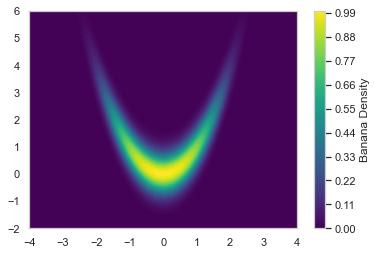

In [94]:
x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-2, 6, 100)
X_bb, Y_bb = np.meshgrid(x_bb, y_bb) # evaluate barp on this grid
Z_bb = np.zeros((100, 100)) 

for i in range(100):
    for j in range(100):
        Z_bb[i, j] = bar_p([X_bb[i, j], Y_bb[i, j]])
# plot barp
contour = plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='viridis')
plt.colorbar(contour, label = 'Banana Density')
plt.show()

The gradient of the prior's log-density is given by : 
$\nabla_x \log p_\theta(x) = (2\theta_1 x_1 - 4\theta_3 x_1 (x_2 - x_1^2)  ;  2\theta_2 x_2 + 2 \theta_3 (x_2 - x_1^2))$

In [96]:
def grad_banana_gen(x, theta) : 

    grad_x = np.zeros_like(x)
    
    grad_x[:, 0] = 2 * theta[0] * x[:, 0] - 4 * theta[2] * (x[:, 1] - x[:, 0]**2) * x[:, 0]
    
    grad_x[:, 1] = 2 * theta[1] * x[:, 1] + 2 * theta[2] * (x[:, 1] - x[:, 0]**2)
    
    return grad_x

In [102]:
def grad_banana(x):

    grad = -x/5

    grad[:, 0] += 8 * x[:, 0] * (x[:, 1] - x[:, 0]**2)

    grad[:, 1] -= 4 * (x[:, 1] - x[:, 0]**2)

    return grad


No handles with labels found to put in legend.


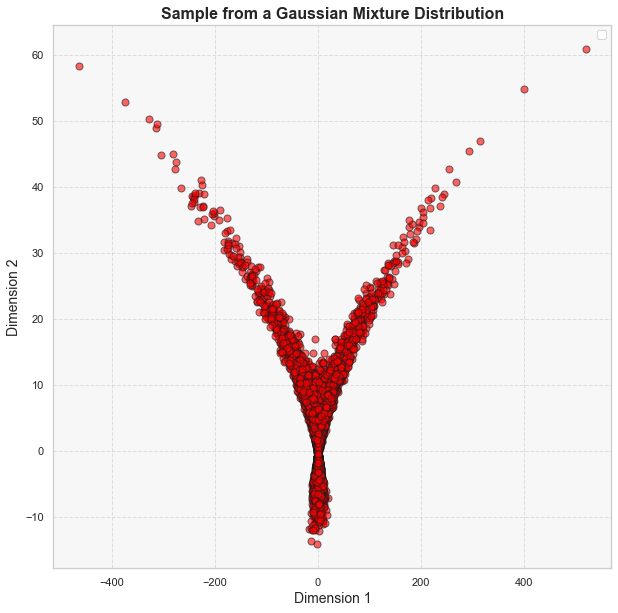

No handles with labels found to put in legend.


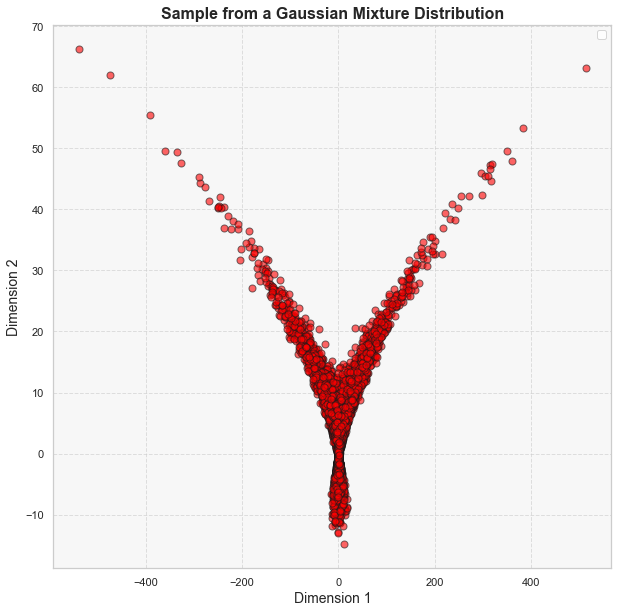

In [103]:
sample_init = np.random.randn(10000, 2)

plot_sample_dx(grad_banana_gen(sample_init, theta_star))

sample_init = np.random.randn(10000, 2)

plot_sample_dx(grad_banana(sample_init))

We define ULA to be able to sample from this prior distribution 

In [111]:
def ULA_banana(sample, nb_iter, step_size, plot = False):

    sample_size = sample.shape[0]

    dim_var = sample.shape[1]

    for i in range(nb_iter) :

        grad = grad_banana(sample)

        sample += step_size * grad + np.sqrt(2*step_size) * np.random.randn(sample_size, dim_var) #MOINS Gradient du potentiel
    
    if plot : 

        plot_sample_dx(sample, 'Banana Prior')

    return sample

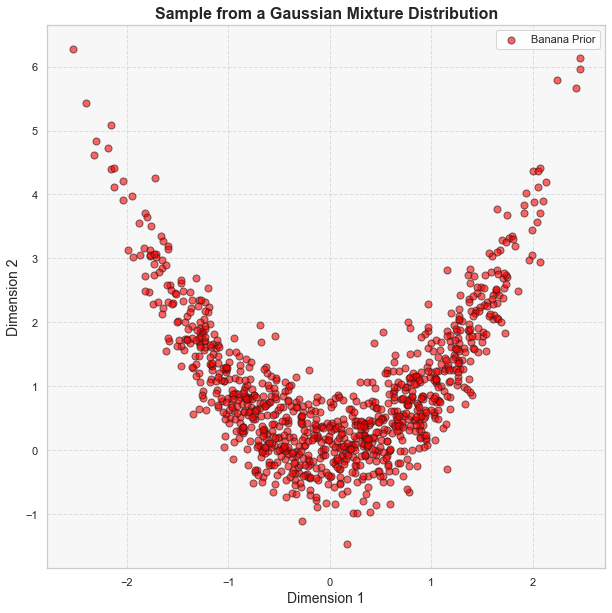

Nb NaN 0


In [113]:
sample_init = np.random.randn(1000, 2)

x = ULA_banana(sample_init, 50000, 0.001, plot=True)

print(f'Nb NaN {np.sum(np.isnan(x))}')

The drift term of the prior distribution is superlinear, at least in some directions : 

/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_21801/1545989476.py:5: RuntimeWarning: invalid value encountered in true_divide
  grad[i] = grad_banana(np.array([[0.1*i, 0.1*i], [0.1*i, 0.1*i]]))[0] / np.linalg.norm(np.array([0.1*i, 0.1*i]))
No handles with labels found to put in legend.


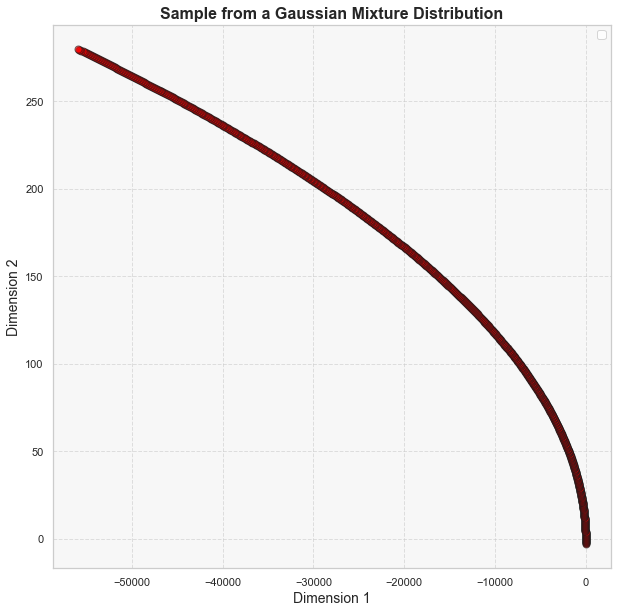

In [117]:
grad = np.zeros((1000, 2))

for i in range(1000):

    grad[i] = grad_banana(np.array([[0.1*i, 0.1*i], [0.1*i, 0.1*i]]))[0] / np.linalg.norm(np.array([0.1*i, 0.1*i]))
    #grad[i] = grad_banana(np.array([[0.1*i, 0.1*i], [0.1*i, 0.1*i]]))[0]

plot_sample_dx(grad)

As in this exercise, we set $y_{obs} = 1$, $\sigma_y = 0.05$ and $H = (1, 0)$, then we can try to sample from the posterior distribution given by :

$p_{\theta}(x) \propto p_\theta(x) p(y \mid x)$

In [172]:
y_obs = 1
sigma_y = 0.05
H = np.array([1, 0])

Now ULA used to sample from posterior distribution

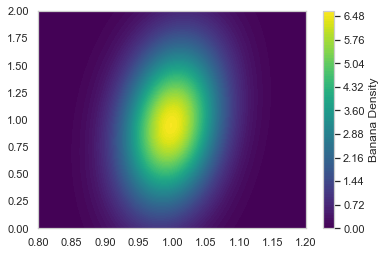

In [138]:
x_axis = np.linspace(0.8, 1.2, 100)
y_axis = np.linspace(0, 2, 100)
X_axis, Y_axis = np.meshgrid(x_axis, y_axis) # evaluate barp on this grid
Z = np.zeros((100, 100)) 

for i in range(100):
    for j in range(100):
        Z[i, j] = bar_p([X_axis[i, j], Y_axis[i, j]]) * norm.pdf(y_obs, H @ np.array([X_axis[i, j], Y_axis[i, j]]), sigma_y)

# plot barp
contour = plt.contourf(X_axis, Y_axis, Z, 100, cmap='viridis')
plt.colorbar(contour, label = 'Banana Density')
plt.show()

In [212]:
def ULA_post_banana(sample, nb_iter, step_size, theta, y_obs, sigma_y):

    sample_size = sample.shape[0]

    dim_var = sample.shape[1]

    for i in tqdm(range(nb_iter)) :

        grad = grad_banana(sample)

        grad += (1/sigma_y**2) * (y_obs - theta[:, np.newaxis].T * sample) * theta

        sample += step_size * grad + np.sqrt(2*step_size) * np.random.randn(sample_size, dim_var) #MOINS Gradient du potentiel

        if np.sum(np.isnan(sample)) // 2 > 850: 
            return 'Too much NaN'
    
    plot_sample_dx(sample, 'Banana Prior')

    return sample

We sample from the posterior distribution via ULA : 

100%|██████████| 20000/20000 [00:03<00:00, 5570.42it/s]


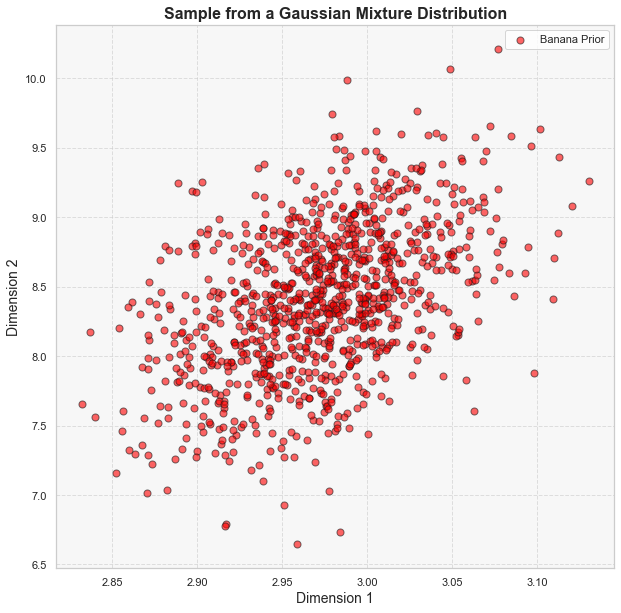

array([[3.015901  , 8.8722775 ],
       [2.97223069, 9.02830306],
       [2.95456137, 8.95316018],
       ...,
       [2.94693389, 8.51007617],
       [2.86638348, 8.30436692],
       [2.97131138, 8.59654252]])

In [220]:
sample_init = ULA_banana(np.random.randn(1000, 2), 50000, 0.001) ## Sample from prior
ULA_post_banana(sample_init, 20000, 0.0001, H, 1, 0.05)

Before trying to estimate the maximum marginal likelihood (with H as the parameter) of the observation, we compute the marginal likelihood depending on H to see if the model is identifiable : 

$p_H(y_{obs}) = \int p(x).p_H(y \mid x) dx $

Here, we just plot the distribution of y for H = (3, 2)

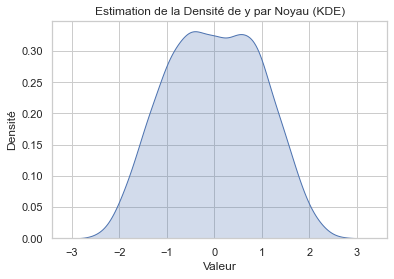

In [223]:
sample_prior = ULA_banana(np.random.randn(3000, 2), 50000, 0.001) ## Sample from prior
sample_noise = np.random.randn(3000) * sigma_y

sample_obs = np.array([1, 0]) @ sample_prior.T + sample_noise

sns.kdeplot(sample_obs, fill=True)
plt.title('Estimation de la Densité de y par Noyau (KDE)')
plt.xlabel('Valeur')
plt.ylabel('Densité')
plt.show()

Here, for $y_{obs} = 1$, we compute the likelihood for several values of H

In [151]:
sample_prior = ULA_banana(np.random.randn(3000, 2), 50000, 0.001) ## Sample from prior

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [05:31<00:00, 11.05s/it]


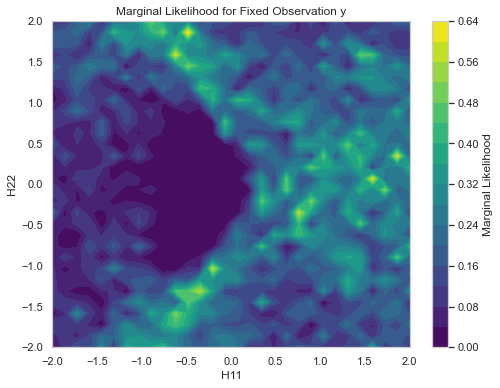

In [157]:
def likelihood(y, x, H, sigma=0.05):
    mean = H @ x
    cov = sigma**2
    return norm.pdf(y, mean, cov)

def marginal_likelihood(y, H, sample_prior):
    likelihoods = [likelihood(y, x, H) for x in sample_prior]
    return np.mean(likelihoods)

H11 = np.linspace(-2, 2, 30)
H22 = np.linspace(-2, 2, 30)
H_grid = np.meshgrid(H11, H22)
Z = np.zeros_like(H_grid[0])

for i in tqdm(range(len(H11))):
    for j in range(len(H22)):
        H = np.array([H11[i], H22[j]])
        Z[i, j] = marginal_likelihood(y_obs, H, sample_prior)

plt.figure(figsize=(8, 6))
contour = plt.contourf(H11, H22, Z, levels=20, cmap='viridis')
plt.colorbar(contour, label='Marginal Likelihood')
plt.xlabel('H11')
plt.ylabel('H22')
plt.title('Marginal Likelihood for Fixed Observation y')
plt.show()


In [197]:

def PGD_ban(nb_particles, nb_iter, step_size, H_0, sigma_y, y_obs, plot = False, sample_prior = None) : 
    """
    This function executes the Particle Gradient Descent in the context of our experiment. Given :
    - The number of particles
    - The number of iterations
    - The step size
    - Parameters of the prior distribution
    - The observed data point "y"
    - The initializing H_0
    """

    theta_t = H_0

    dx = H_0.shape[0]

    if sample_prior is None :
        sample = ULA_banana(np.random.randn(nb_particles, dx), 20000, 0.001) ## Sample from prior
    else : 
        sample = np.copy(sample_prior)
    

    theta_traj = np.zeros((nb_iter, dx))

    for i in range(nb_iter) : 

        grad = grad_banana(sample)

        grad += (1/sigma_y**2) * theta_t * (y_obs - theta_t[:, np.newaxis].T * sample)

        sample += step_size * grad + np.sqrt(2*step_size) * np.random.randn(nb_particles, dx)

        ## MAJ du theta
        grad_theta = grad_theta_GM(sample, theta_t, y_obs, sigma_y) #renvoie un vecteur avec tous les gradients

        grad_theta_update = np.sum(grad_theta, axis = 0) ## ON MULTIPLIE CHAQUE PARTICLE A SON PAS SPECIFIQUE

        theta_t = theta_t - (step_size / nb_particles) * grad_theta_update 

        theta_traj[i] = theta_t

        if np.sum(np.isnan(sample)) // dx > 0.9*nb_particles:

            print('Too many NaN in the sample')
            
            return sample, theta_t, theta_traj

    if plot : 

        plot_sample_dx(sample, 'Banana Posterior')

        plt.figure(figsize=(10, 8))

        plt.plot(theta_traj[:, 0], theta_traj[:, 1], 'o-', markersize=4, label='Theta Trajectory')

    return sample, theta_t, theta_traj

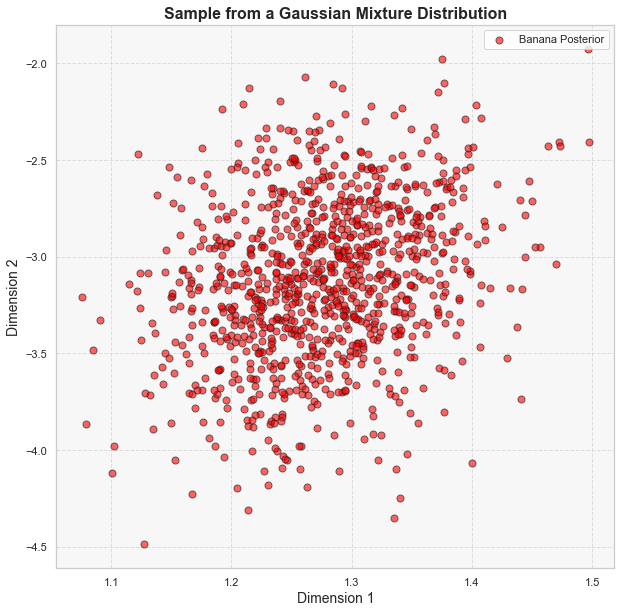

(array([[ 1.2378363 , -4.00494959],
        [ 1.29704832, -3.64404474],
        [ 1.26442244, -2.34845689],
        ...,
        [ 1.4314599 , -3.16133498],
        [ 1.19894025, -3.30971124],
        [ 1.27042377, -2.92999489]]),
 array([ 0.633797  , -0.06080579]),
 array([[ 0.96292831,  0.0400824 ],
        [ 0.93137706,  0.07499613],
        [ 0.90432044,  0.10543014],
        ...,
        [ 0.63380943, -0.06079136],
        [ 0.63380349, -0.06080295],
        [ 0.633797  , -0.06080579]]))

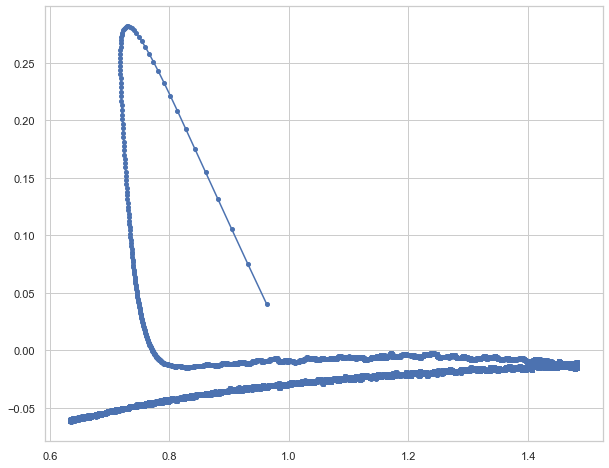

In [219]:
PGD_ban(1000, 50000, 0.0001, np.array([1, 0]), 0.05, 1, plot = True, sample_prior = None)

In [194]:
sample_prior = ULA_banana(np.random.randn(1000, 2), 50000, 0.001) ## Sample from prior

100%|██████████| 80/80 [09:32<00:00,  7.16s/it]


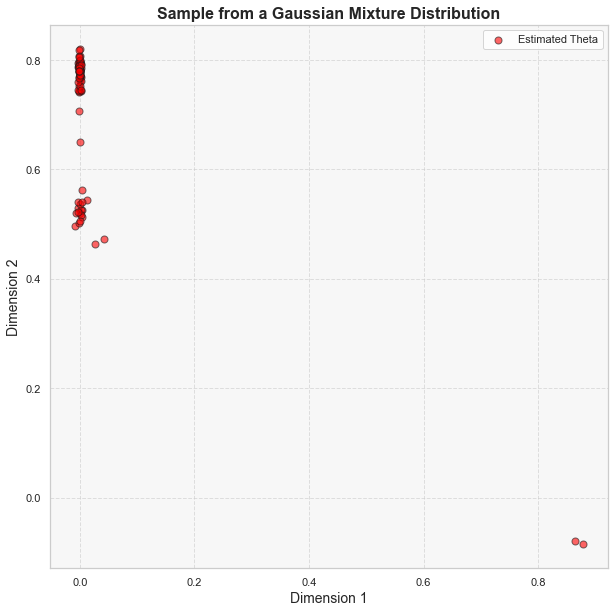

In [209]:
## Initialization of theta at origin
theta_estimated_list = np.zeros((80, 2))
theta_0_list = np.random.uniform(-0.5, 0.5, (80, 2))

for i in tqdm(range(80)):

    sample, theta_t, theta_traj = PGD_ban(1000, 25000, 0.001, theta_0_list[i], 0.05, 1, plot = False, sample_prior = sample_prior)
    theta_estimated_list[i] = theta_t

plot_sample_dx(theta_estimated_list, 'Estimated Theta')